In [1]:
import sys
sys.path.append("../script")
from data_preparation import *
from utils import GridScore
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Logit

# Import et préparation des données

In [2]:
train = pd.read_csv("../data/application_train_vf.csv")
test = pd.read_csv("../data/application_test_vf.csv")

Type des variables convertis ✅
Valeurs manquantes traitées ✅
Discrétisation des variables numériques en cours ... 


  0%|          | 0/17 [00:00<?, ?it/s]

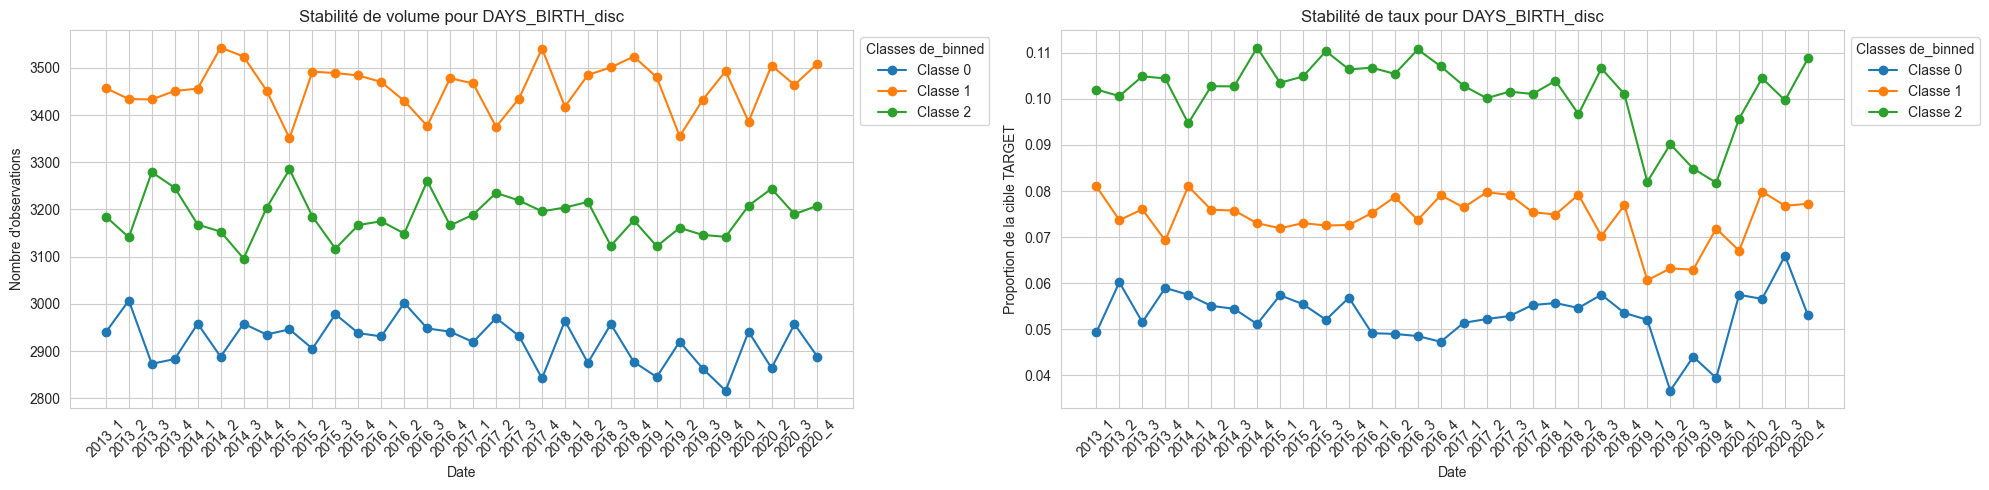

  6%|▌         | 1/17 [00:17<04:43, 17.75s/it]

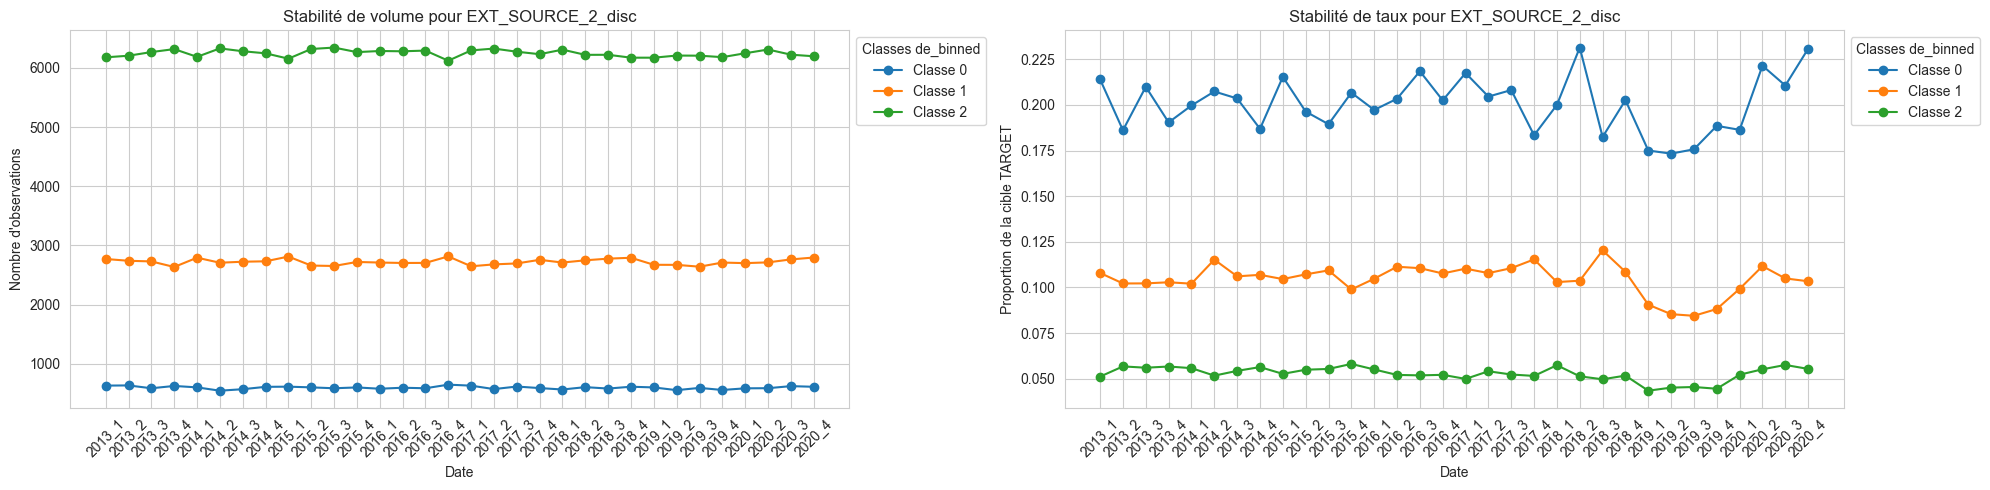

 12%|█▏        | 2/17 [00:36<04:35, 18.36s/it]

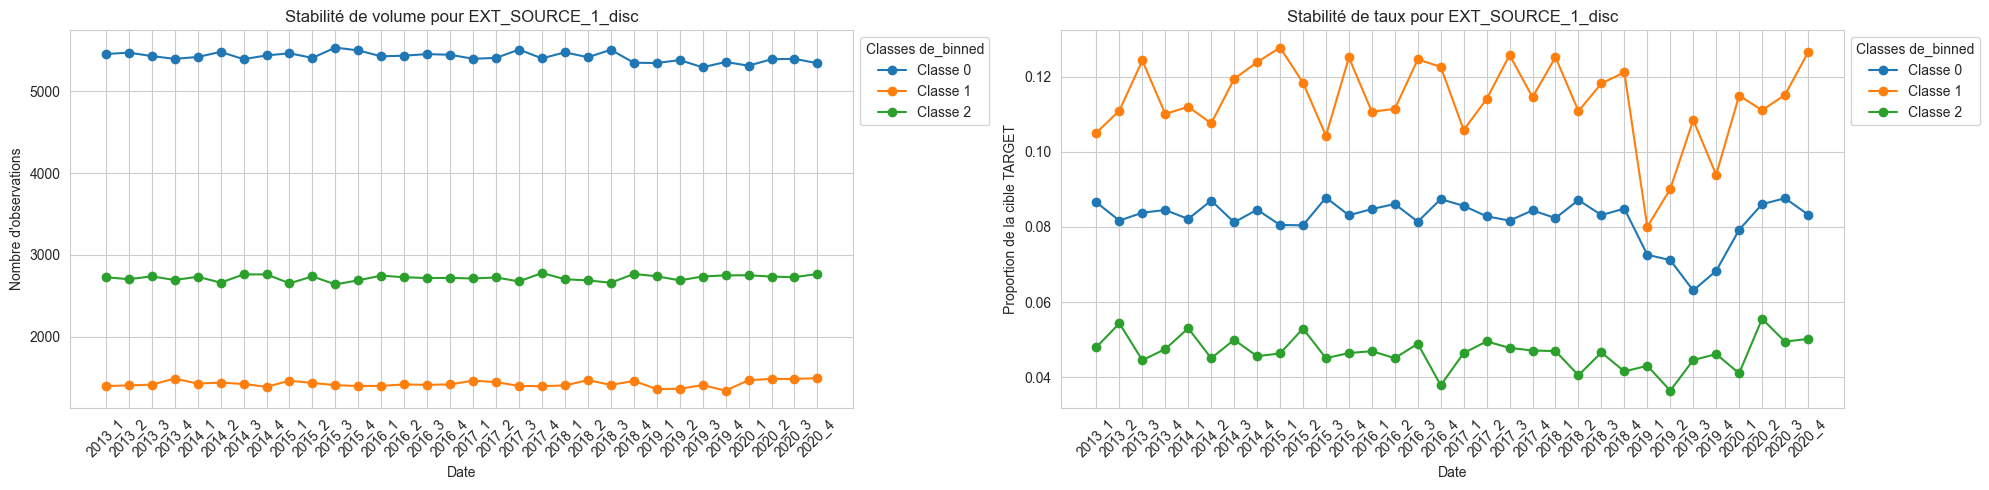

 18%|█▊        | 3/17 [00:57<04:34, 19.63s/it]

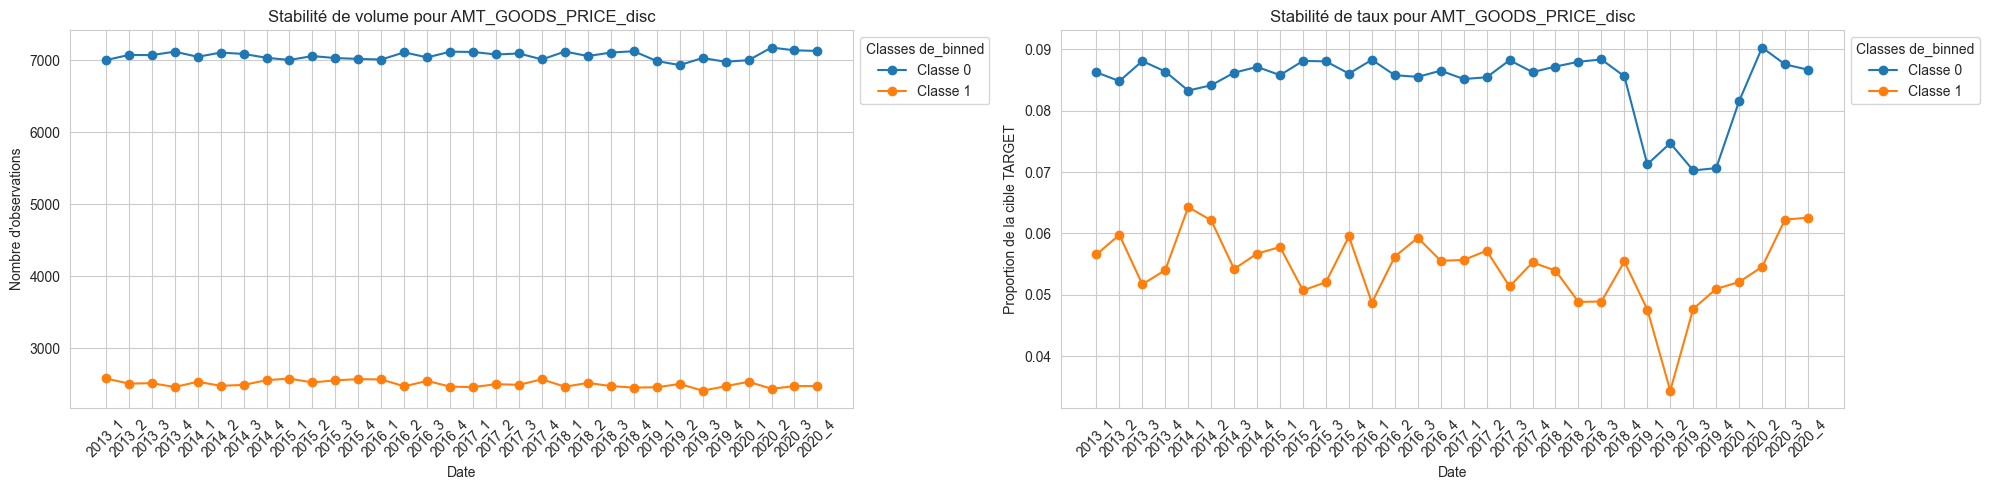

 24%|██▎       | 4/17 [01:15<04:07, 19.01s/it]

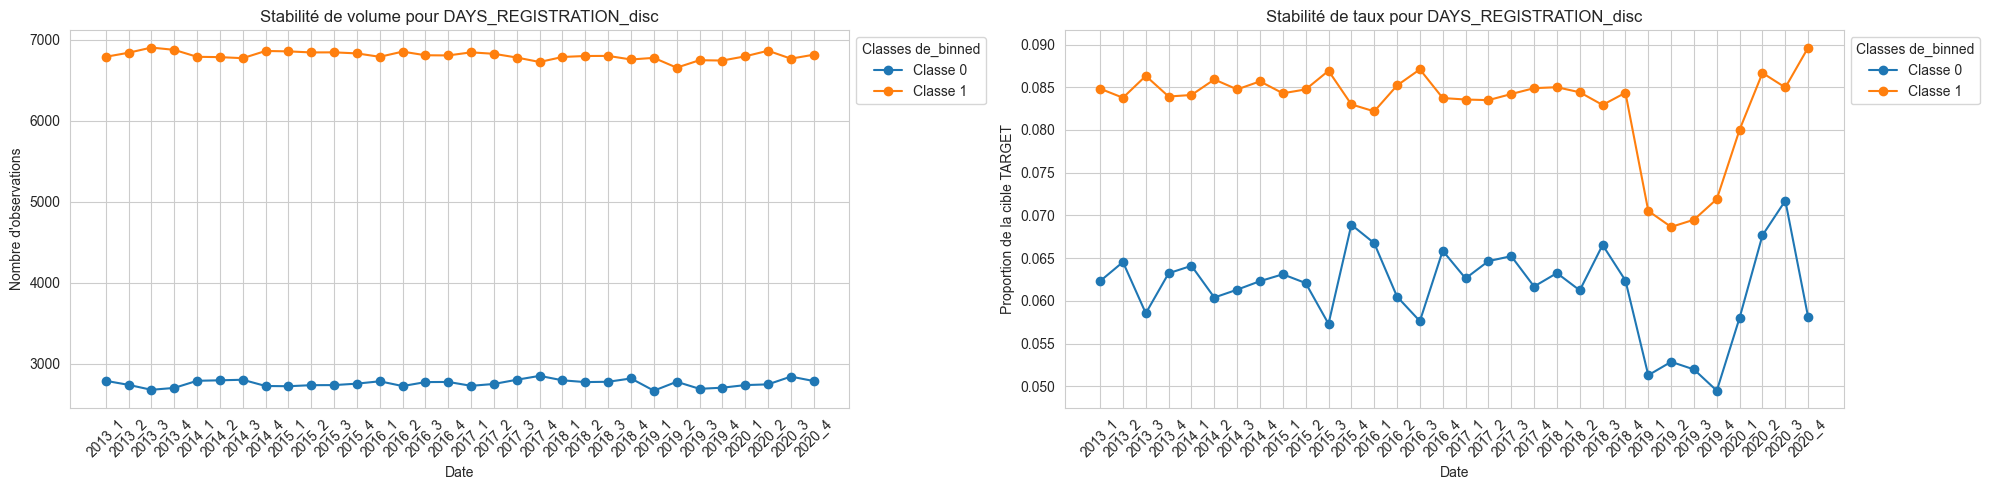

 29%|██▉       | 5/17 [01:33<03:44, 18.69s/it]

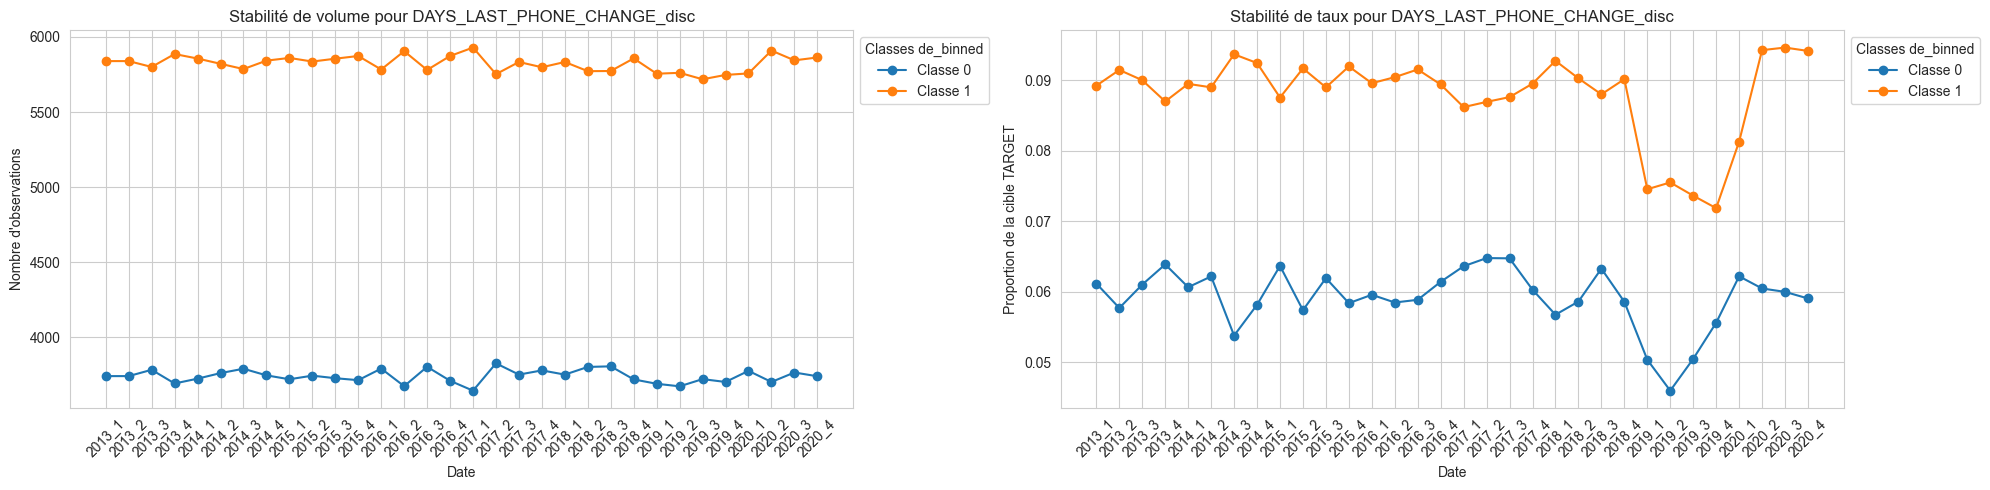

 35%|███▌      | 6/17 [01:51<03:22, 18.44s/it]

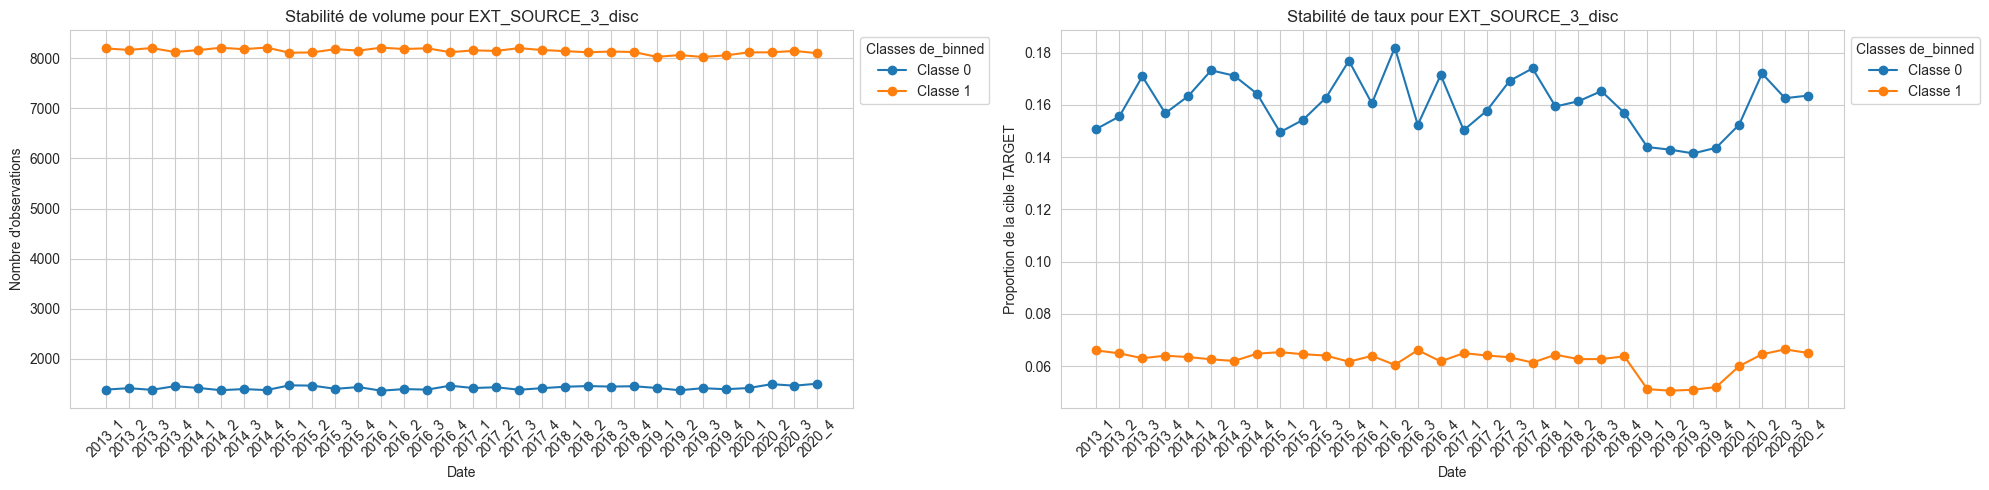

 41%|████      | 7/17 [02:08<02:59, 17.95s/it]

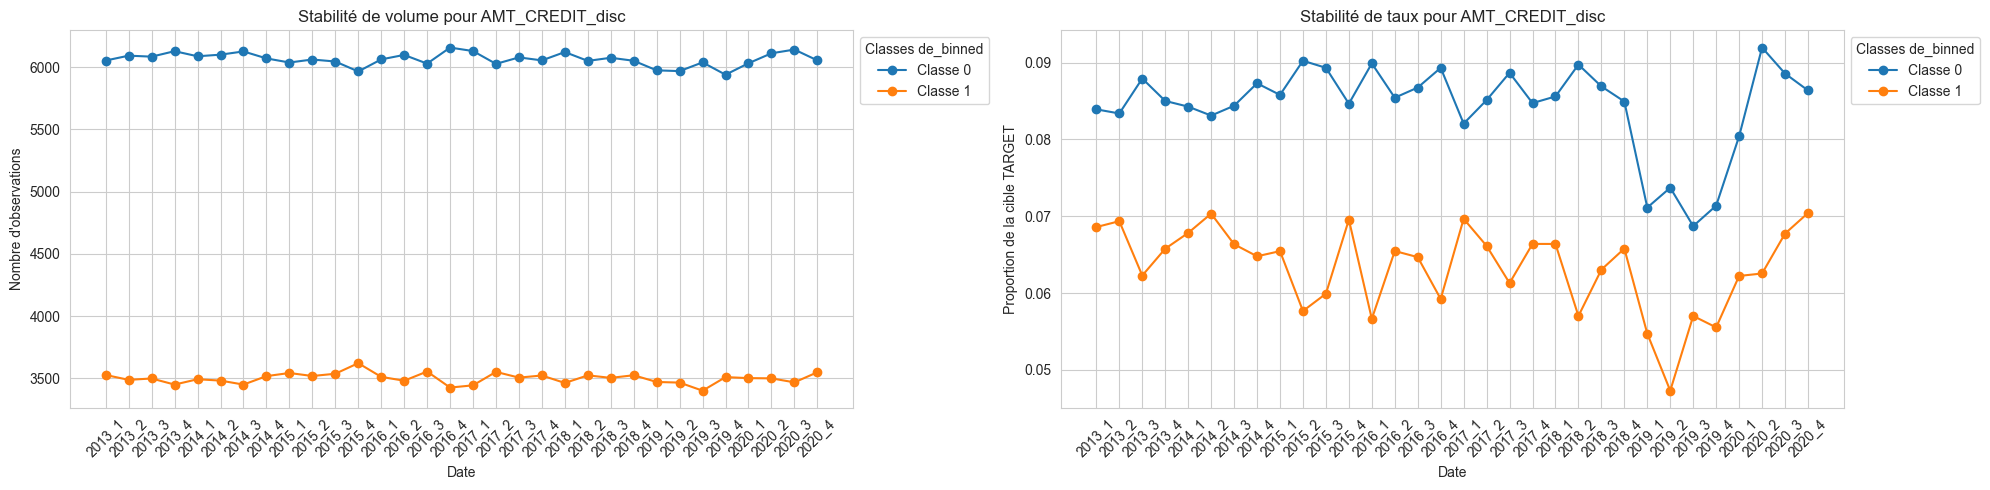

 47%|████▋     | 8/17 [02:26<02:40, 17.86s/it]

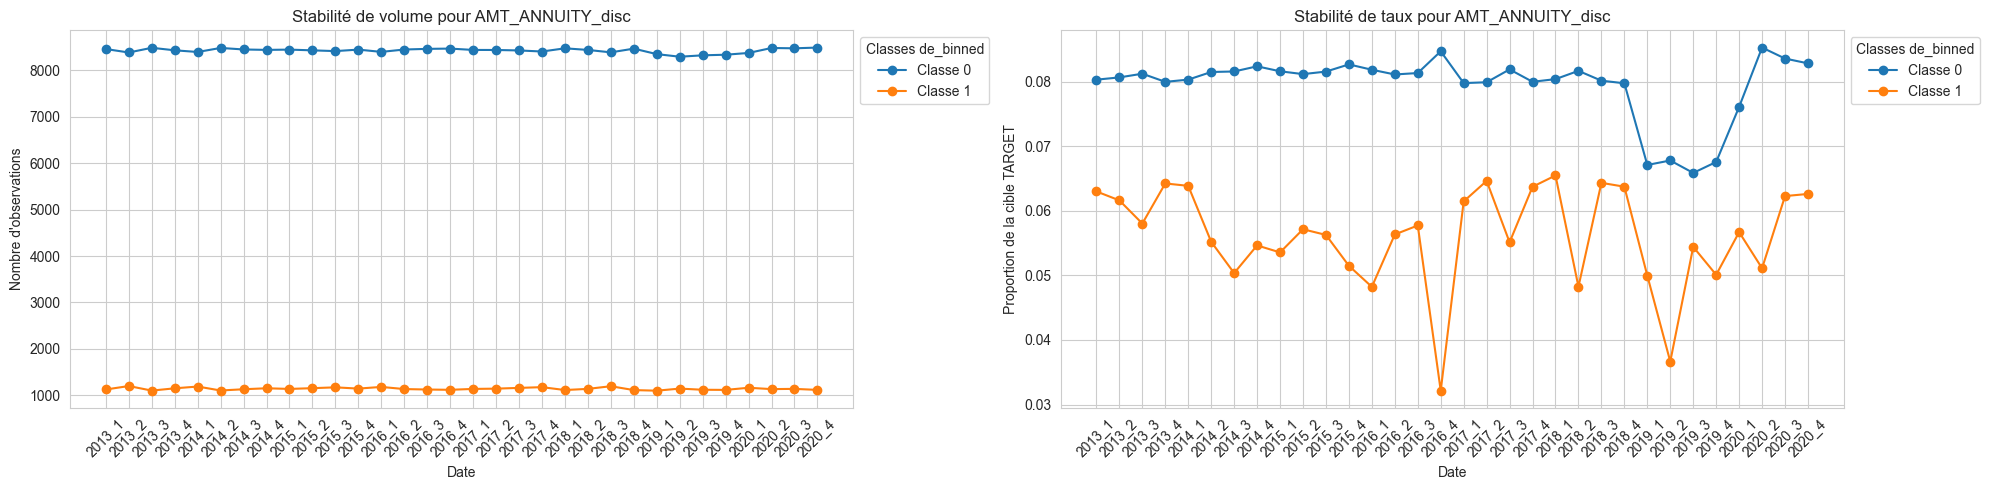

 53%|█████▎    | 9/17 [02:42<02:18, 17.34s/it]

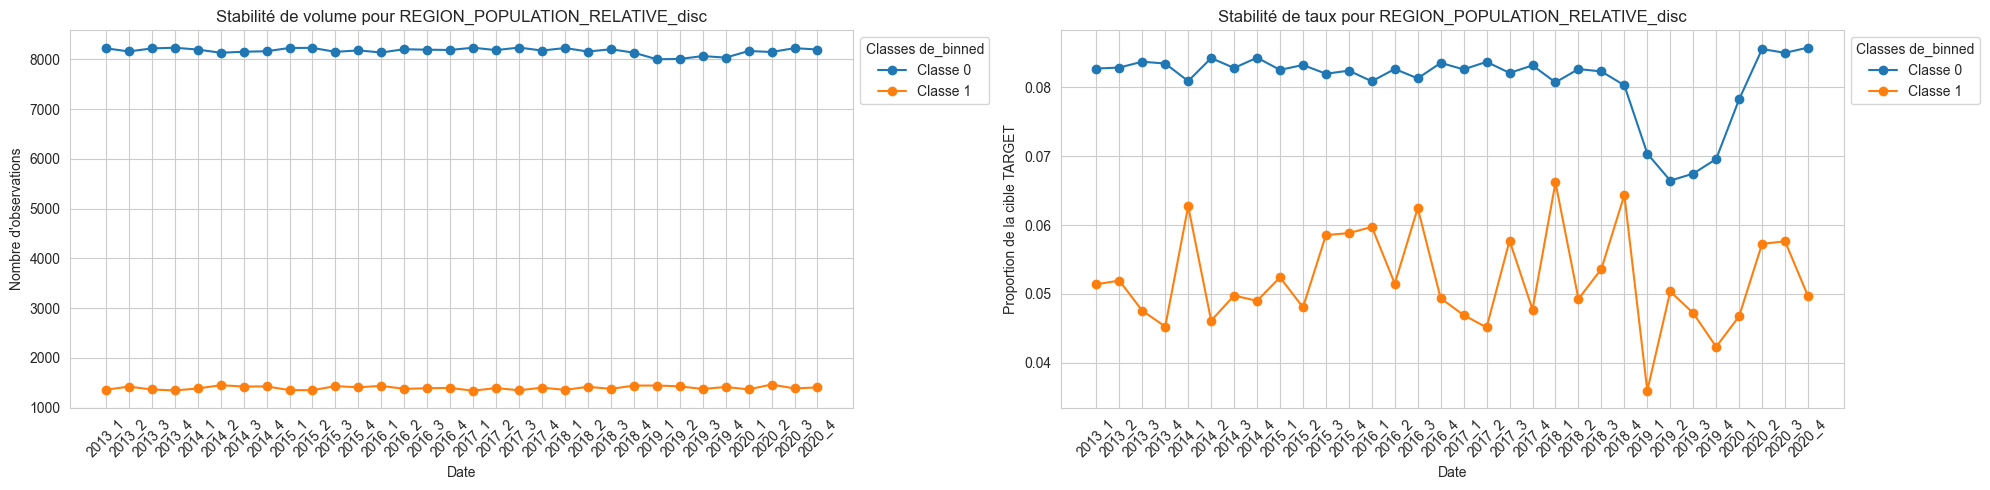

 59%|█████▉    | 10/17 [02:59<02:00, 17.18s/it]

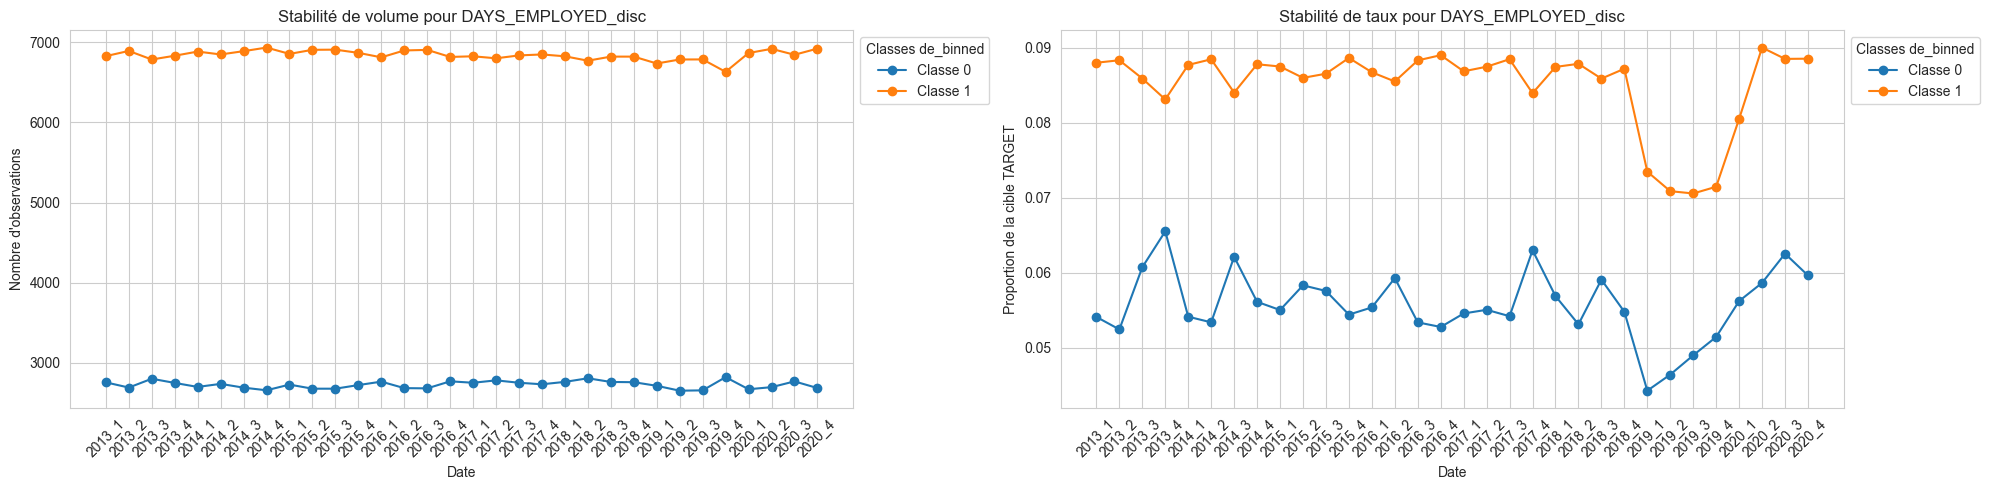

 65%|██████▍   | 11/17 [03:15<01:40, 16.74s/it]

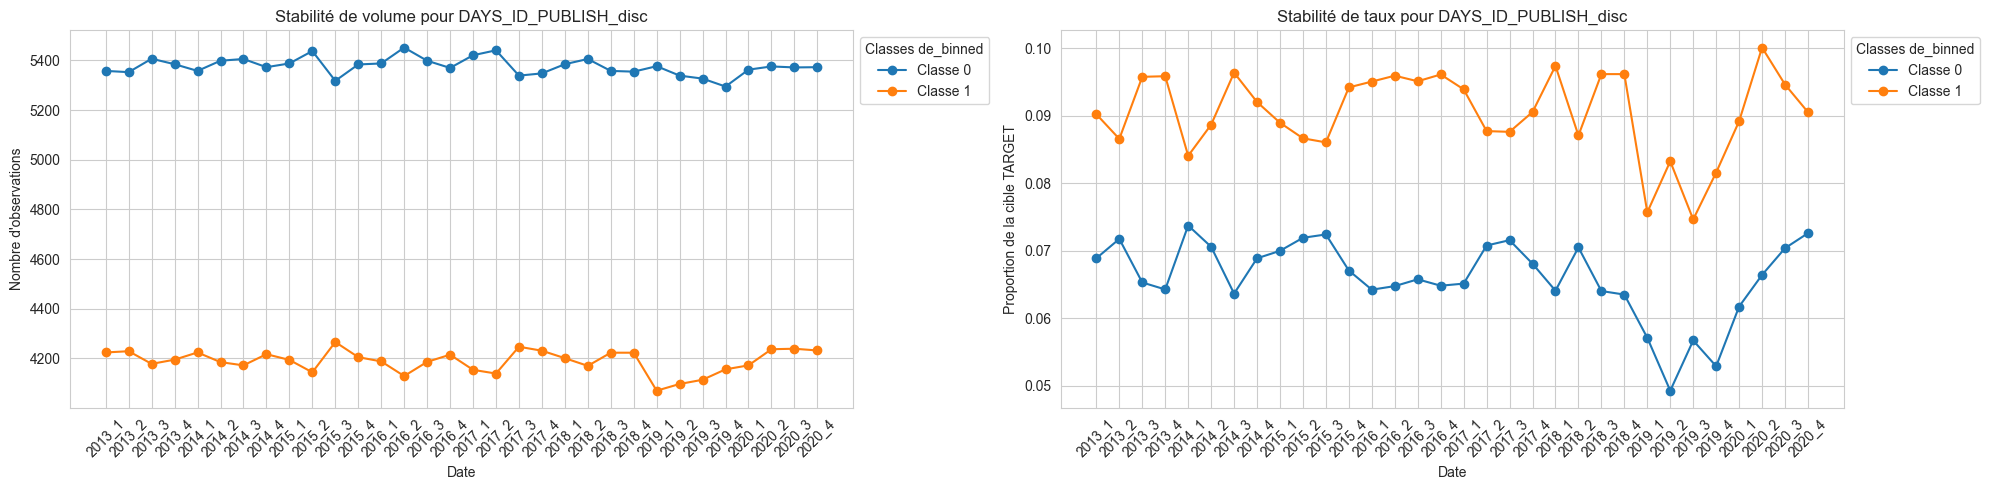

 71%|███████   | 12/17 [03:30<01:21, 16.39s/it]

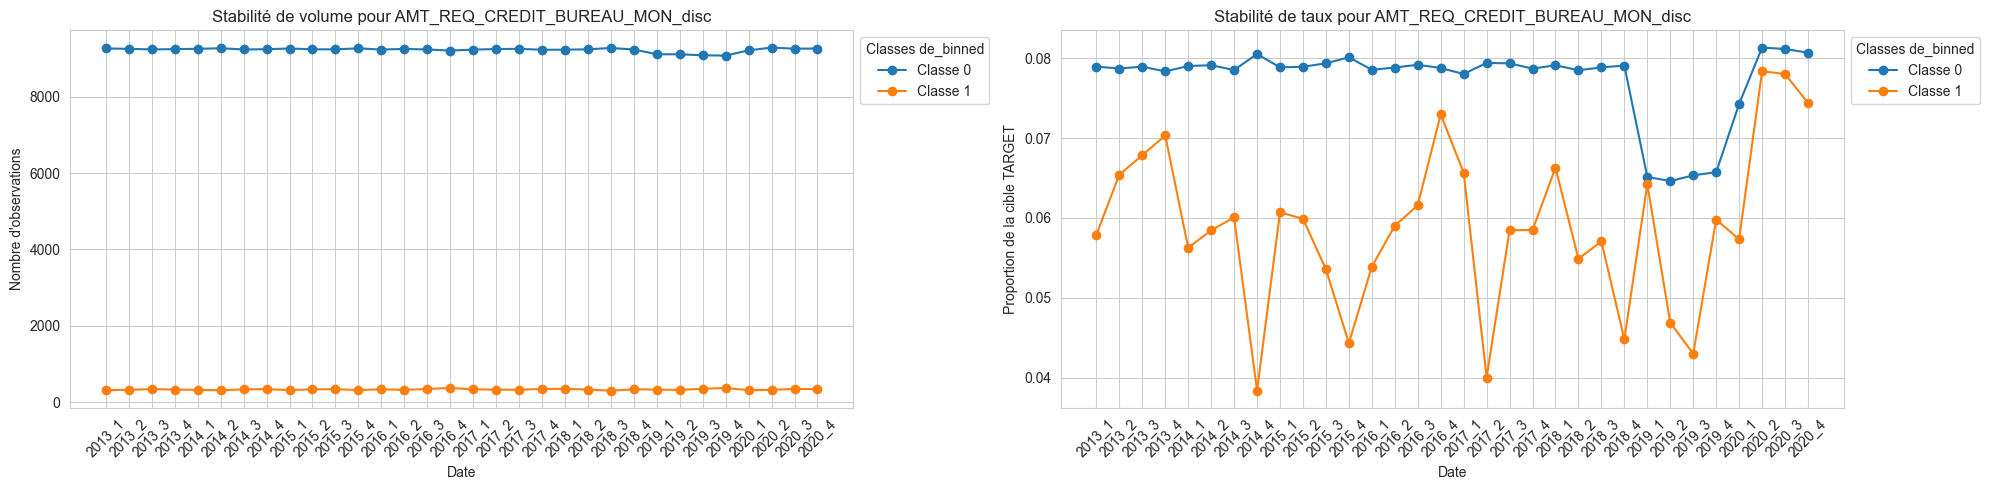

 76%|███████▋  | 13/17 [03:46<01:04, 16.09s/it]

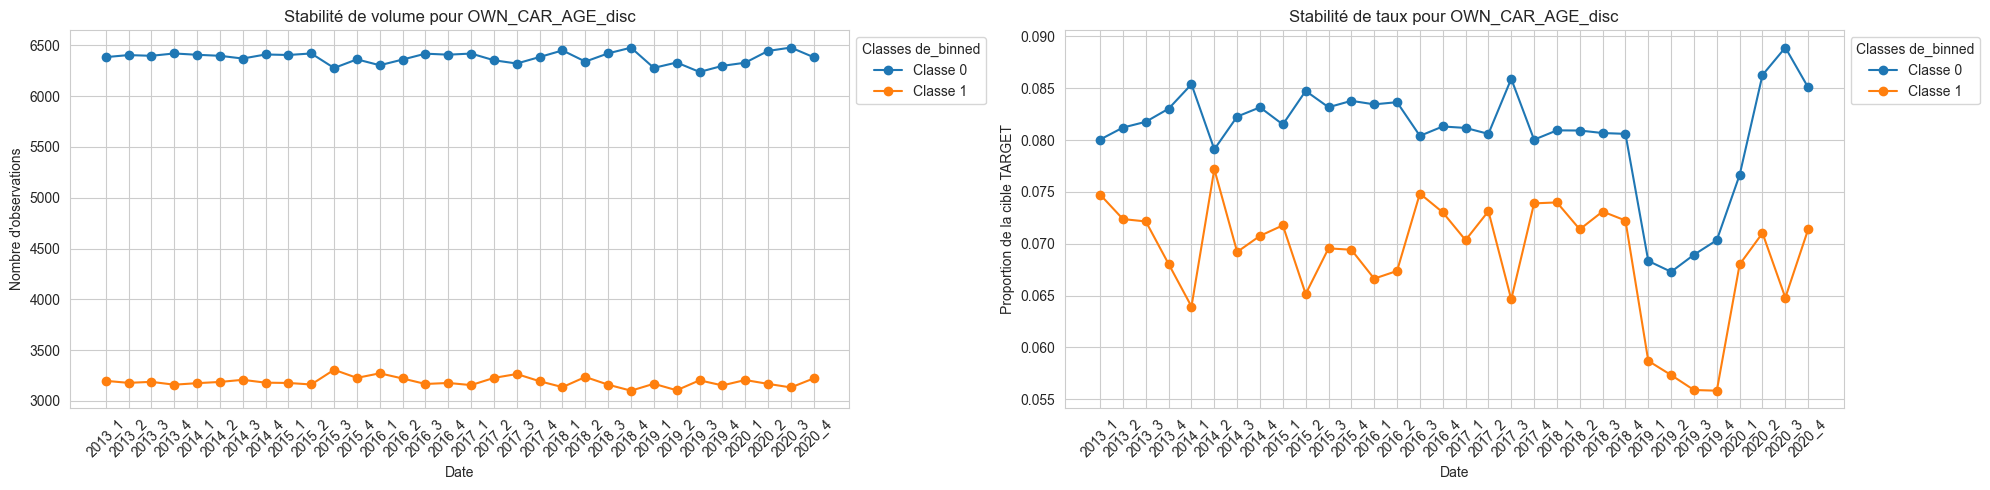

 82%|████████▏ | 14/17 [04:01<00:48, 16.01s/it]

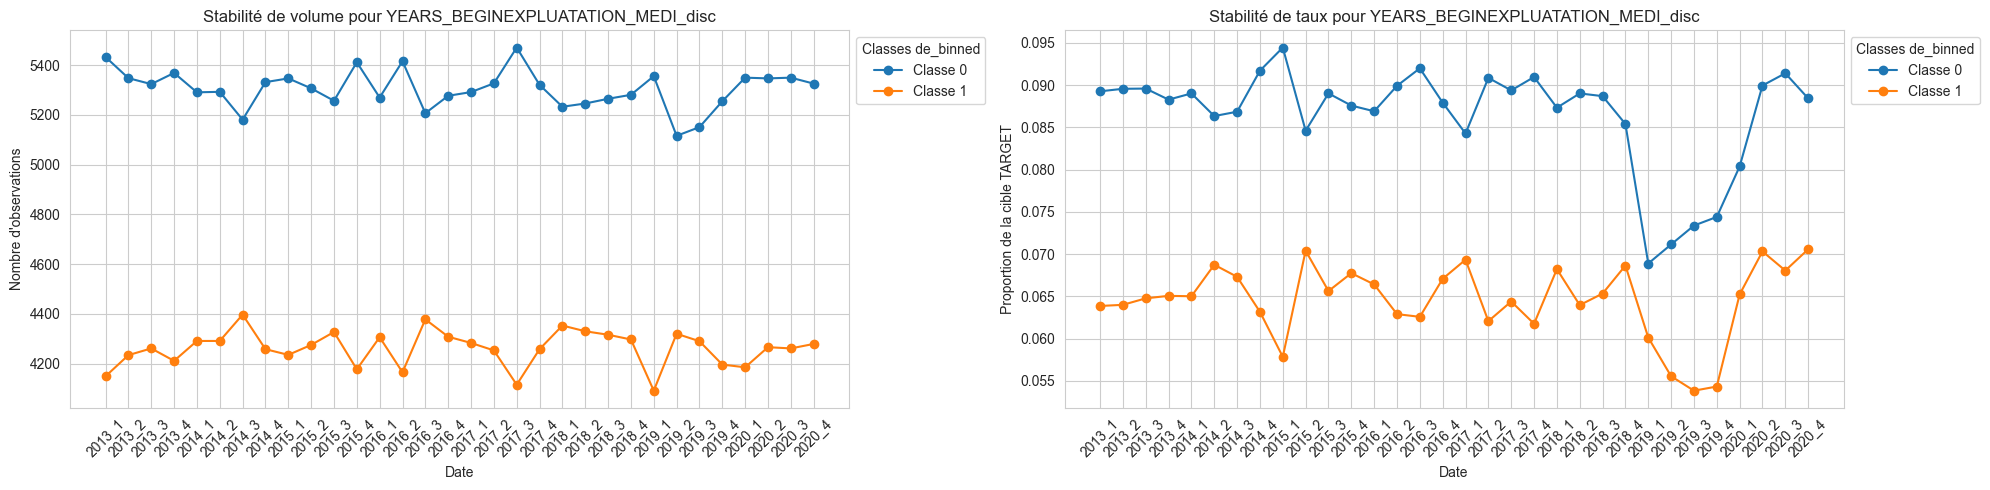

 88%|████████▊ | 15/17 [04:19<00:33, 16.57s/it]

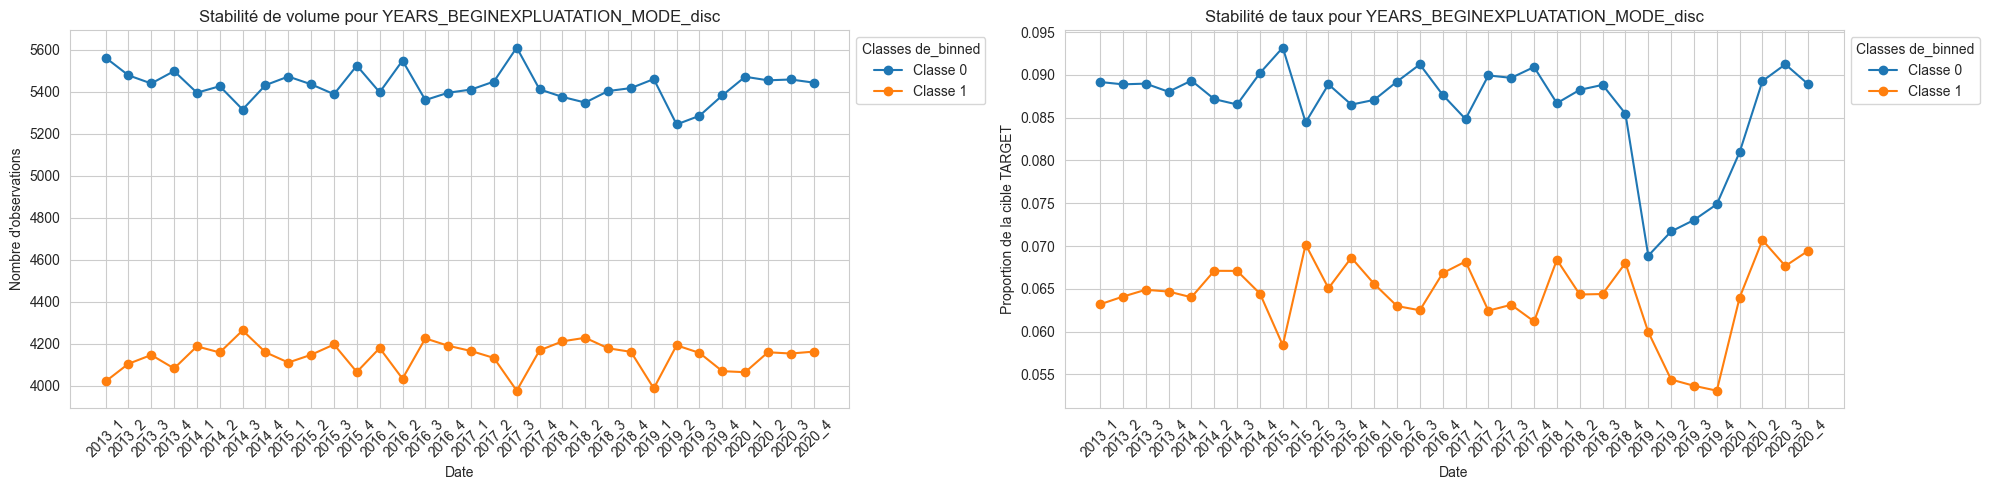

 94%|█████████▍| 16/17 [04:36<00:16, 16.71s/it]

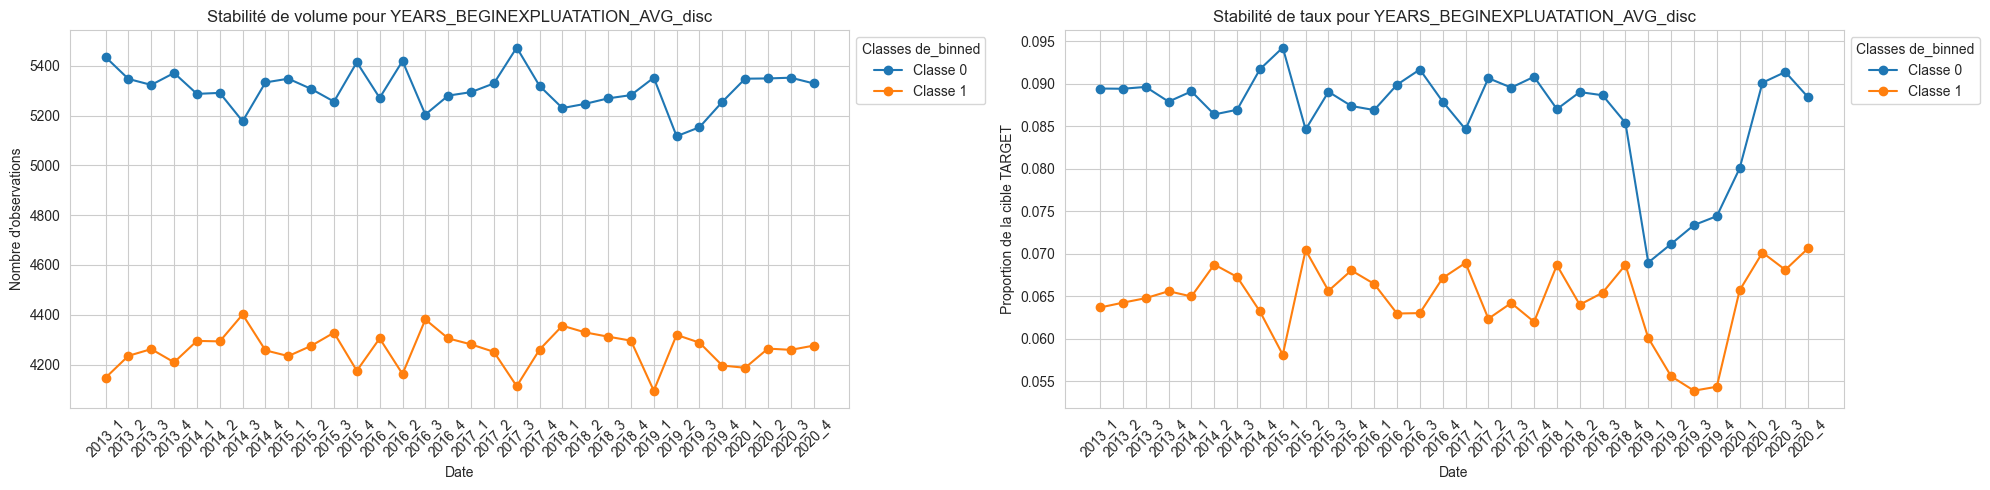

100%|██████████| 17/17 [04:54<00:00, 17.30s/it]


Variables numériques discrétisées ✅
Discrétisation des variables catégorielles en cours ... 
Variables catégorielles discrétisées ✅


In [3]:
dataprep = DataPreparation(train, test, 0.3, plot = True)
train_prepared, test_prepared = dataprep.get_prepared_data()

In [4]:
train_prepared.to_csv("../data/train_prepared.csv")
test_prepared.to_csv("../data/test_prepared.csv")
#train_prepared = pd.read_csv("../data/train_prepared.csv", index_col=[0])
#test_prepared = pd.read_csv("../data/test_prepared.csv", index_col=[0])

In [4]:
df_train = train_prepared.copy()

In [5]:
df_train["TARGET"] = df_train["TARGET"].astype("int")

In [6]:
df_validation = df_train.iloc[280000:,:]
df_train = df_train.iloc[:280000,:]

# Modélisation

In [7]:
features = list(df_train.iloc[:,2:7].columns)

In [8]:
formula = f'TARGET ~ {" + ".join(f"C({var})" for var in features)}'

In [9]:
reference_categories = {var : df_train[var].mode()[0] for var in features}

In [10]:
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')
    else:
        formula_parts.append(f'C({var})')  # Ou simplement 'var' si c'est une variable continue

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

In [11]:
model = Logit.from_formula(formula=formula, data=df_train)
logit_model = model.fit_regularized(maxiter = 500, method='l1')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2538339716351152
            Iterations: 67
            Function evaluations: 67
            Gradient evaluations: 67


# Prédiction

In [12]:
pred = logit_model.predict(df_validation[features])

In [13]:
pred = pred.apply(lambda x : 0 if x < 0.5 else 1)

/Users/axel/Documents/École/Université/M2/M2_S1/Challenge_Nexialog/venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


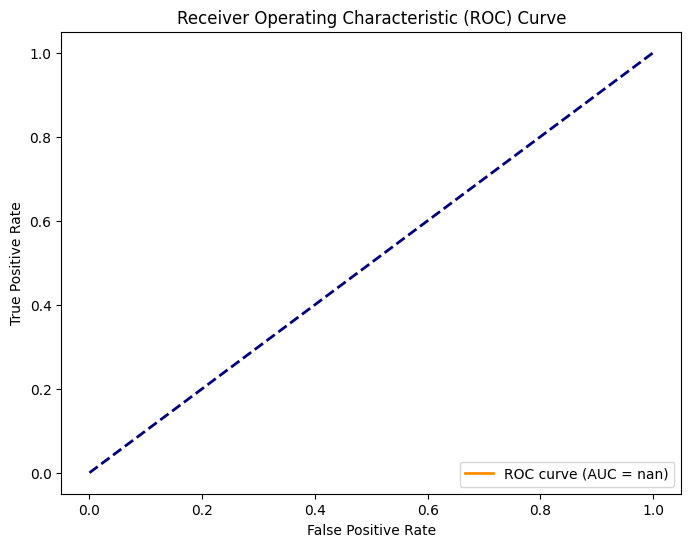

In [14]:
fpr, tpr, thresholds = roc_curve(pred, df_validation["TARGET"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [15]:
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

nan

# Grille de score